In [1]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import TsModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [ ]:
"""
This test the filtered small wind turbine data
all spikes >1000 are removed 

"""

In [21]:
exp30_3_results = {
    'gp_tsl_train_accuracy':gp_tsl_train_accuracy,
    'gp_tsl_test_accuracy':gp_tsl_test_accuracy,
    'gp_tsl_r2s':gp_tsl_r2s,
    'gp_tsl_time':gp_tsl_time,
    'gp_tsc_train_accuracy':gp_tsc_train_accuracy,
    'gp_tsc_test_accuracy':gp_tsc_test_accuracy,
    'gp_tsc_r2s':gp_tsc_r2s,
    'gp_tsc_time':gp_tsc_time,
    'gp_nn_tsl_train_accuracy':gp_nn_tsl_train_accuracy,
    'gp_nn_tsl_test_accuracy':gp_nn_tsl_test_accuracy,
    'gp_nn_tsl_r2s':gp_nn_tsl_r2s,
    'nn_tsl_r2s':nn_tsl_r2s,
    'gp_nn_tsl_time':gp_nn_tsl_time,
}

In [22]:
#%store exp30_3_results 

Stored 'exp30_3_results' (dict)


In [2]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/small_wind_turbine_x_train.csv')
x_test = pd.read_csv('Data/FES/small_wind_turbine_x_test.csv')
y_train = pd.read_csv('Data/FES/small_wind_turbine_y_train.csv')
y_test = pd.read_csv('Data/FES/small_wind_turbine_y_test.csv')

In [3]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(9, activation=keras.activations.tanh))    
    model.add(layers.Dense(18, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [4]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [8]:
nn_train_accuracy = []
nn_test_accuracy = []
nn_r2s = []
nn_time = []
histories = []

def do_nn_exp():
    for fold in range(number_of_folds):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()]
        )

        start_time = time.time()
        history = neural_network_model.fit(
            x_train, 
            y_train,
            epochs=100, 
            shuffle=True
        )
        time_used = time.time() - start_time

        _, train_rmse = neural_network_model.evaluate(x_train, y_train)
        nn_train_accuracy.append(train_rmse)
        _, test_rmse = neural_network_model.evaluate(x_test, y_test)
        nn_test_accuracy.append(test_rmse)
        nn_r2 = r2_score(y_test, neural_network_model.predict(x_test))
        nn_r2s.append(nn_r2)
        nn_time.append(time_used)
        histories.append(history)
    
    return neural_network_model

In [9]:
nn_model = do_nn_exp()

Epoch 1/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 6339.0654 - root_mean_squared_error: 79.5255
Epoch 2/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 3452.7866 - root_mean_squared_error: 58.7128
Epoch 3/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1931.6001 - root_mean_squared_error: 43.9198
Epoch 4/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1125.3711 - root_mean_squared_error: 33.5200
Epoch 5/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 655.3100 - root_mean_squared_error: 25.5761
Epoch 6/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 380.1398 - root_mean_squared_error: 19.4880
Epoch 7/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 245.2724 - root_mean_squared_error: 15.6535
Epoch 8/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 171.4861 - root_mean_squared_error: 13.0891
Epoch 9/100
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 137.6471 - root_mean_squared_error: 11.7299
Epoch 10/100
4137/4137 ━

In [10]:
nn_train_accuracy_mean = np.round(np.mean(nn_train_accuracy), 3)
nn_train_accuracy_std = np.round(np.std(nn_train_accuracy), 3)
nn_test_accuracy_mean = np.round(np.mean(nn_test_accuracy), 3)
nn_test_accuracy_std = np.round(np.std(nn_test_accuracy),3)
nn_r2_mean = np.round(np.mean(nn_r2s),3)
nn_r2_std = np.round(np.std(nn_r2s),3)
nn_time_mean = np.round(np.mean(nn_time),3)
nn_time_std = np.round(np.std(nn_time),3)

print(f"NN Train RMSE: {nn_train_accuracy_mean} ± {nn_train_accuracy_std}")
print(f"NN Test RMSE: {nn_test_accuracy_mean} ± {nn_test_accuracy_std}")
print(f"NN R2: {nn_r2_mean} ± {nn_r2_std}")
print(f"NN Time: {nn_time_mean} ± {nn_time_std}")

NN Train RMSE: 7.402 ± 0.184
NN Test RMSE: 7.572 ± 0.191
NN R2: 0.991 ± 0.0
NN Time: 3089.637 ± 1103.83


In [11]:
nn_model.save('small_wind_filtered_nn.keras')

In [12]:
def get_tsl_model(x_train, y_train, number_of_rules):
    tsl_model = TsModel.TsModel(number_of_rules, fuzzification_coefficient=1.2)
    tsl_model.fit(x_train, y_train)
    return tsl_model

def get_tsc_model(x_train, y_train, number_of_rules):
    tsc_model = TsModel_constant.TsModel_constant(number_of_rules, fuzzification_coefficient=1.2)
    tsc_model.fit(x_train, y_train)
    return tsc_model

# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

number_of_rules_array = [2,3,4,5,8,10,15,20,25]

FCM training RMSE: 20.037384019004644
FCM training RMSE: 20.023709010150156
FCM training RMSE: 20.03094347979988
FCM training RMSE: 19.98039837991981
FCM training RMSE: 20.008368564659452
FCM training RMSE: 20.01320163143011
FCM training RMSE: 20.00973134633216
FCM training RMSE: 20.017155245354722
FCM training RMSE: 20.05836132953552
FCM training RMSE: 19.980747425502322
FCM training RMSE: 19.216898889372082
FCM training RMSE: 20.812433495241468
FCM training RMSE: 19.22491654524639
FCM training RMSE: 19.171263351486154
FCM training RMSE: 19.203713568064504
FCM training RMSE: 19.196925234787297
FCM training RMSE: 19.18915295125342
FCM training RMSE: 19.206333817654617
FCM training RMSE: 20.85258531983962
FCM training RMSE: 20.788228309241156
FCM training RMSE: 14.47281334869955
FCM training RMSE: 20.119133642289885
FCM training RMSE: 20.12063335733788
FCM training RMSE: 20.07129325263272
FCM training RMSE: 20.09241287434099
FCM training RMSE: 20.106218267133727
FCM training RMSE: 20.10

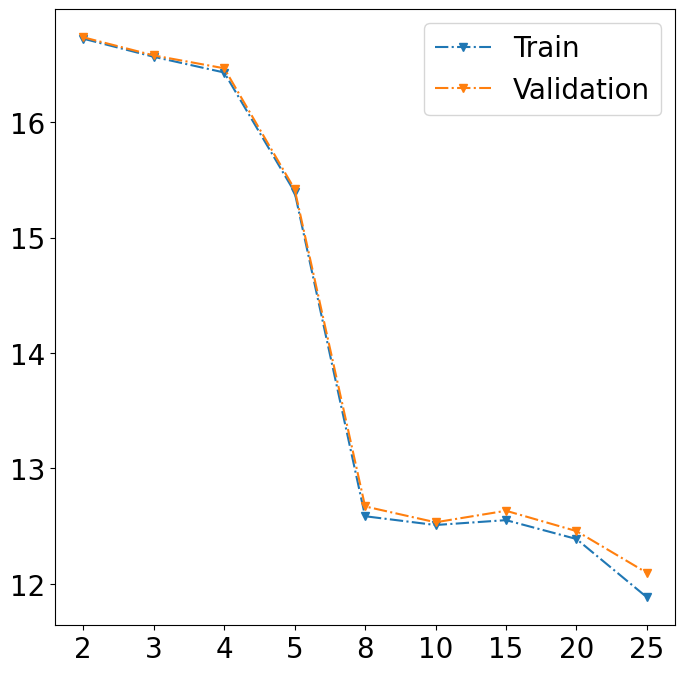

In [6]:
# Use validation to get the optimal number of rules
tsl_cv_train_accuracy = []
tsl_cv_val_accuracy = []

kf = KFold(n_splits=number_of_folds)

for number_of_rules in number_of_rules_array:
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        ts_model = TsModel.TsModel(number_of_rules, fuzzification_coefficient=1.2)
        
        start_time = time.time()
        ts_model.fit(x_train[train_index], y_train[train_index])
        time_used = time.time() - start_time

        tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train[train_index]))
        tsl_val_pred = ts_relu_wrapper(ts_model.predict(x_train[test_index]))

        train_rmse = root_mean_squared_error(y_train[train_index], tsl_train_pred)
        val_rmse = root_mean_squared_error(y_train[test_index], tsl_val_pred)

        tsl_cv_train_accuracy.append(train_rmse)
        tsl_cv_val_accuracy.append(val_rmse)


# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_cv_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='Train')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_cv_val_accuracy).reshape(-1, 10), axis=1), '-.v', label='Validation')


plt.legend()
plt.show()

(140876, 20)
[[9.71998336e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99998858e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99969177e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.75983667e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.02050248e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.85836992e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(140876, 2)
[[9.71998336e-01 2.80016641e-02]
 [9.99998858e-01 1.14204594e-06]
 [9.99969177e-01 3.08225502e-05]
 ...
 [1.75983667e-06 9.99998240e-01]
 [1.02050248e-07 9.99999898e-01]
 [8.85836992e-07 9.99999114e-01]]
FCM training RMSE: 93.14511100417255
(140876, 20)
[[5.10623270e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99918065e-01 0.000

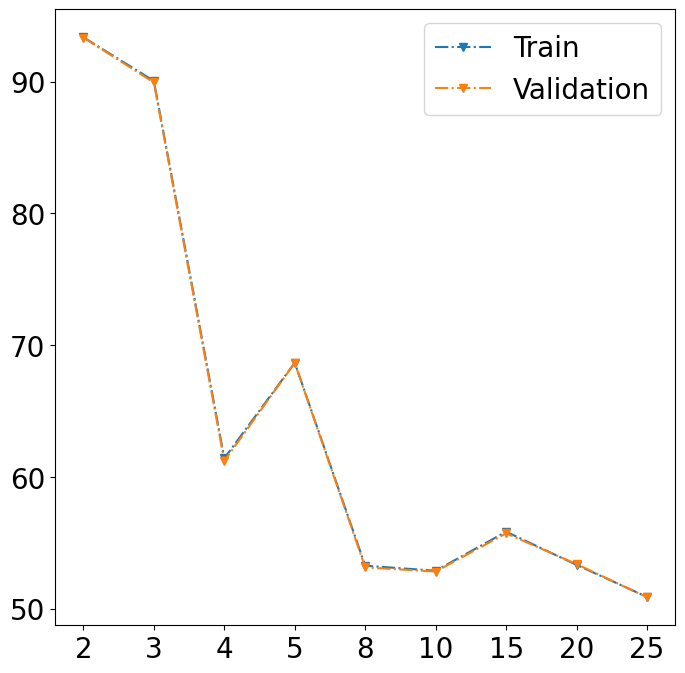

In [12]:
# Use validation to get the optimal number of rules
tsc_cv_train_accuracy = []
tsc_cv_val_accuracy = []

kf = KFold(n_splits=number_of_folds)

for number_of_rules in number_of_rules_array:
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        ts_model = TsModel_constant.TsModel_constant(number_of_rules, fuzzification_coefficient=1.2)
        
        start_time = time.time()
        ts_model.fit(x_train[train_index], y_train[train_index])
        time_used = time.time() - start_time

        tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train[train_index]))
        tsc_val_pred = ts_relu_wrapper(ts_model.predict(x_train[test_index]))

        train_rmse = root_mean_squared_error(y_train[train_index], tsc_train_pred)
        val_rmse = root_mean_squared_error(y_train[test_index], tsc_val_pred)

        tsc_cv_train_accuracy.append(train_rmse)
        tsc_cv_val_accuracy.append(val_rmse)


# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_cv_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='Train')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_cv_val_accuracy).reshape(-1, 10), axis=1), '-.v', label='Validation')


plt.legend()
plt.show()

In [13]:

# TS with linear conclusion
tsl_opt_train_accuracy = []
tsl_opt_test_accuracy = []
tsl_r2s = []
tsl_time = []
tsl_model = None

for fold in range(number_of_folds):
    ts_model = TsModel.TsModel(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsl_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsl_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsl_test_pred)

    tsl_opt_train_accuracy.append(train_rmse)
    tsl_opt_test_accuracy.append(test_rmse)
    tsl_r2 = r2_score(y_test, tsl_test_pred)
    tsl_r2s.append(tsl_r2)
    tsl_time.append(time_used)
    tsl_model = ts_model

tsl_train_accuracy_mean = np.round(np.mean(tsl_opt_train_accuracy), 3)
tsl_train_accuracy_std = np.round(np.std(tsl_opt_train_accuracy), 3)
tsl_test_accuracy_mean = np.round(np.mean(tsl_opt_test_accuracy), 3)
tsl_test_accuracy_std = np.round(np.std(tsl_opt_test_accuracy),3)
tsl_r2_mean = np.round(np.mean(tsl_r2s),3)
tsl_r2_std = np.round(np.std(tsl_r2s),3)
tsl_time_mean = np.round(np.mean(tsl_time),3)
tsl_time_std = np.round(np.std(tsl_time),3)

print(f"TS Linear Train RMSE: {tsl_train_accuracy_mean} ± {tsl_train_accuracy_std}")
print(f"TS Linear Test RMSE: {tsl_test_accuracy_mean} ± {tsl_test_accuracy_std}")
print(f"TS Linear R2: {tsl_r2_mean} ± {tsl_r2_std}")
print(f"TS Linear Time: {tsl_time_mean} ± {tsl_time_std}")

FCM training RMSE: 12.78505238428026
FCM training RMSE: 12.862266542055387
FCM training RMSE: 12.686996449064287
FCM training RMSE: 12.1262157085917
FCM training RMSE: 12.85967775095869
FCM training RMSE: 12.073633319638358
FCM training RMSE: 12.146227887903631
FCM training RMSE: 13.6930175590605
FCM training RMSE: 12.785043488661664
FCM training RMSE: 12.806723898189993
TS Linear Train RMSE: 11.924 ± 0.329
TS Linear Test RMSE: 12.125 ± 0.382
TS Linear R2: 0.978 ± 0.001
TS Linear Time: 89.007 ± 7.549


In [14]:
# TS model
# Constant conclusion
tsc_opt_train_accuracy = []
tsc_opt_test_accuracy = []
tsc_r2s = []
tsc_time = []
tsc_model = None

for fold in range(number_of_folds):
    ts_model = TsModel_constant.TsModel_constant(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsc_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsc_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsc_test_pred)

    tsc_opt_train_accuracy.append(train_rmse)
    tsc_opt_test_accuracy.append(test_rmse)
    tsc_r2 = r2_score(y_test, tsc_test_pred)
    tsc_r2s.append(tsc_r2)
    tsc_time.append(time_used)
    tsc_model = ts_model

tsc_train_accuracy_mean = np.round(np.mean(tsc_opt_train_accuracy), 3)
tsc_train_accuracy_std = np.round(np.std(tsc_opt_train_accuracy), 3)
tsc_test_accuracy_mean = np.round(np.mean(tsc_opt_test_accuracy), 3)
tsc_test_accuracy_std = np.round(np.std(tsc_opt_test_accuracy),3)
tsc_r2_mean = np.round(np.mean(tsc_r2s),3)
tsc_r2_std = np.round(np.std(tsc_r2s),3)
tsc_time_mean = np.round(np.mean(tsc_time),3)
tsc_time_std = np.round(np.std(tsc_time),3)

print(f"TS Constant Train RMSE: {tsc_train_accuracy_mean} ± {tsc_train_accuracy_std}")
print(f"TS Constant Test RMSE: {tsc_test_accuracy_mean} ± {tsc_test_accuracy_std}")
print(f"TS Constant R2: {tsc_r2_mean} ± {tsc_r2_std}")
print(f"TS Constant Time: {tsc_time_mean} ± {tsc_time_std}")

(132380, 250)
[[1.09481024e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.85439148e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.51792244e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [3.54963414e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.63251645e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.92469376e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 25)
[[1.09481024e-11 5.58177667e-11 9.37526945e-10 ... 7.50922871e-09
  1.39445965e-08 7.05381961e-11]
 [1.85439148e-10 1.50889707e-09 1.01096232e-07 ... 1.40304267e-08
  3.40178778e-06 6.11184524e-09]
 [1.51792244e-06 1.03494521e-06 4.00817561e-03 ... 9.79493046e-01
  1.42194194e-04 6.56715371e-06]
 ...
 [3.54963414e-05 7.89723769e-01 2.19653481e-06 ... 8.26118194e-07
  8.1

In [15]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []
gpr_model = None

for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    indices = np.random.choice(x_train.shape[0], 2000, replace=False)      

    start_time = time.time()
    gpr_model.fit(x_train[indices,:], y_train[indices,:])
    time_used = time.time() - start_time

    train_means = gpr_model.predict(x_train)
    test_means = gpr_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)

gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GP Train RMSE: 27.704 ± 30.129
GP Test RMSE: 28.309 ± 30.921
GP R2: 0.739 ± 0.473
GP Time: 321.398 ± 175.394


In [16]:
# GPR from TS linear
gp_tsl_train_accuracy = []
gp_tsl_test_accuracy = []
tsl_train_accuracy = []
tsl_test_accuracy = []
gp_tsl_r2s = []
gp_tsl_time = []
gpr_tsl_model = None

# From ts linear
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
        gpr_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsl_model = get_tsl_model(x_train, y_train, number_of_rules)

        start_time = time.time()
        gpr_tsl_model.fit(tsl_model.cen, tsl_model.predict(tsl_model.cen + 1e-8))
        time_used = time.time() - start_time

        gp_train_means = gpr_tsl_model.predict(x_train)
        gp_test_means = gpr_tsl_model.predict(x_test)

        tsl_train_means = tsl_model.predict(x_train)
        tsl_test_means = tsl_model.predict(x_test)

        gp_train_rmse = root_mean_squared_error(y_train, gp_train_means)
        gp_test_rmse = root_mean_squared_error(y_test, gp_test_means)

        gp_tsl_train_accuracy.append(gp_train_rmse)
        gp_tsl_test_accuracy.append(gp_test_rmse)
        tsl_train_accuracy.append(root_mean_squared_error(y_train, tsl_train_means))
        tsl_test_accuracy.append(root_mean_squared_error(y_test, tsl_test_means))
        gp_r2 = r2_score(y_test, gp_test_means)
        gp_tsl_r2s.append(gp_r2)
        gp_tsl_time.append(time_used)

for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_tsl_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_tsl_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_tsl_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_tsl_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_tsl_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_tsl_time[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


FCM training RMSE: 20.016847995503014
FCM training RMSE: 20.01684802229429
FCM training RMSE: 20.016847986610223
FCM training RMSE: 20.016847992920603
FCM training RMSE: 20.01684799093359
FCM training RMSE: 20.01684798341063
FCM training RMSE: 20.01684798591255
FCM training RMSE: 20.016848006930747


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.016848013491238


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.016847985581748


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.815596370905066
FCM training RMSE: 19.20480269219469
FCM training RMSE: 19.204802692298447
FCM training RMSE: 19.204802691622177


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 19.20480269181481


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 19.204802692312136
FCM training RMSE: 19.204802691780497
FCM training RMSE: 19.204802692225357
FCM training RMSE: 20.815596366465453
FCM training RMSE: 19.20480269151616
FCM training RMSE: 18.82408670527149


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 18.82408670532107
FCM training RMSE: 20.109929716066198
FCM training RMSE: 20.10992971791717
FCM training RMSE: 20.109929718955232
FCM training RMSE: 20.10992971762728


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.109929718149704
FCM training RMSE: 20.10992971782514
FCM training RMSE: 20.109929717397044
FCM training RMSE: 20.109929717482018
FCM training RMSE: 18.511507125568986
FCM training RMSE: 19.711207366587804
FCM training RMSE: 14.12776600074569


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 19.711207366105107
FCM training RMSE: 14.127766000870354
FCM training RMSE: 19.711207366400263
FCM training RMSE: 18.51904740226702
FCM training RMSE: 19.711207366737504
FCM training RMSE: 14.127766000959662


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 19.819619279445256
FCM training RMSE: 13.5869488833887
FCM training RMSE: 13.58464259241373
FCM training RMSE: 14.30495199023598
FCM training RMSE: 13.8123844352422
FCM training RMSE: 13.586948898821616
FCM training RMSE: 13.362653776133826
FCM training RMSE: 13.586948883937556
FCM training RMSE: 12.941367308977423
FCM training RMSE: 14.075236008858113
FCM training RMSE: 14.305163290058749
FCM training RMSE: 13.481311943037719
FCM training RMSE: 13.369641749230087
FCM training RMSE: 13.515202513647681
FCM training RMSE: 13.480895919364015
FCM training RMSE: 13.957324087718636
FCM training RMSE: 13.217675272770558
FCM training RMSE: 14.230939327134912
FCM training RMSE: 13.366378996809447
FCM training RMSE: 12.886431243597361
FCM training RMSE: 14.172546383596973
FCM training RMSE: 13.091635269753521
FCM training RMSE: 13.51151185930646
FCM training RMSE: 13.091621587657041
FCM training RMSE: 13.136250566377628
FCM training RMSE: 13.667882559798574
FCM training RMSE: 

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.796538091619507
FCM training RMSE: 12.885196683888513


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 13.692257470590144


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.084374445731415
FCM training RMSE: 12.792824178493438


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 13.4472644964116
Number of rules: 2
GP Train RMSE: 85.81 ± 4.261
GP Test RMSE: 87.366 ± 4.23
GP R2: -0.137 ± 0.108
GP Time: 0.132 ± 0.007
Number of rules: 3
GP Train RMSE: 77.298 ± 11.337
GP Test RMSE: 78.757 ± 11.416
GP R2: 0.059 ± 0.267
GP Time: 0.129 ± 0.008
Number of rules: 4
GP Train RMSE: 74.718 ± 13.905
GP Test RMSE: 76.108 ± 14.053
GP R2: 0.11 ± 0.318
GP Time: 0.129 ± 0.017
Number of rules: 5
GP Train RMSE: 75.84 ± 15.808
GP Test RMSE: 77.245 ± 15.963
GP R2: 0.075 ± 0.349
GP Time: 0.125 ± 0.016
Number of rules: 8
GP Train RMSE: 68.514 ± 24.674
GP Test RMSE: 69.83 ± 24.945
GP R2: 0.183 ± 0.479
GP Time: 0.127 ± 0.009
Number of rules: 10
GP Train RMSE: 66.164 ± 27.564
GP Test RMSE: 67.38 ± 27.96
GP R2: 0.209 ± 0.511
GP Time: 0.126 ± 0.026
Number of rules: 15
GP Train RMSE: 45.835 ± 28.089
GP Test RMSE: 46.655 ± 28.56
GP R2: 0.555 ± 0.5
GP Time: 0.146 ± 0.016
Number of rules: 20
GP Train RMSE: 29.548 ± 19.808
GP Test RMSE: 30.001 ± 20.169
GP R2: 0.806 ± 0.338
GP 

In [17]:
# GPR model
gp_tsc_train_accuracy = []
gp_tsc_test_accuracy = []
tsc_train_accuracy = []
tsc_test_accuracy = []
gp_tsc_r2s = []
gp_tsc_time = []
gpr_tsc_model = None

# From ts constant
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1e-1, nu=1.5)
        gpr_tsc_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsc_model = get_tsc_model(x_train, y_train, number_of_rules)
        start_time = time.time()
        gpr_tsc_model.fit(tsc_model.cen, tsc_model.predict(tsc_model.cen + 1e-8))
        time_used = time.time() - start_time

        train_means = gpr_tsc_model.predict(x_train)
        test_means = gpr_tsc_model.predict(x_test)
        tsc_train_means = tsc_model.predict(x_train)
        tsc_test_means = tsc_model.predict(x_test)

        train_rmse = root_mean_squared_error(y_train, train_means)
        test_rmse = root_mean_squared_error(y_test, test_means)

        gp_tsc_train_accuracy.append(train_rmse)
        gp_tsc_test_accuracy.append(test_rmse)
        tsc_train_accuracy.append(root_mean_squared_error(y_train, tsc_train_means))
        tsc_test_accuracy.append(root_mean_squared_error(y_test, tsc_test_means))
        gp_r2 = r2_score(y_test, test_means)
        gp_tsc_r2s.append(gp_r2)
        gp_tsc_time.append(time_used)


for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_tsc_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_tsc_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_tsc_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_tsc_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_tsc_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_tsc_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_tsc_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_tsc_time[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")


(132380, 20)
[[1.88199841e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.03867543e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.54866467e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.97708550e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99955907e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.99699435e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 2)
[[1.88199841e-03 9.98118002e-01]
 [2.03867543e-04 9.99796132e-01]
 [8.54866467e-04 9.99145134e-01]
 ...
 [9.97708550e-01 2.29145001e-03]
 [9.99955907e-01 4.40929435e-05]
 [9.99699435e-01 3.00565255e-04]]
FCM training RMSE: 65.73089943947117
(132380, 20)
[[1.88199840e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.03867543e-04 0.000

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 50)
[[9.95120998e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.33751392e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.11780285e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [7.68323261e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.33027176e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.55730677e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 5)
[[9.95120998e-01 4.48017577e-03 5.78726850e-06 3.80013429e-04
  1.30255605e-05]
 [2.33751392e-02 1.18160382e-02 7.06801606e-05 9.64710142e-01
  2.80003773e-05]
 [2.11780285e-01 7.39050833e-01 2.10484534e-04 4.85238375e-02
  4.34559646e-04]
 ...
 [7.68323261e-04 1.48669412e-04 9.83451744e-01 5.13298842e-04
  1.51179649e-02]
 [2.33027176e-05 8.06145952e-05 3.70969470e-01 7.7

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 80)
[[3.27539457e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.77213008e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.67550326e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.03104950e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.69995116e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.47878112e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 8)
[[3.27539457e-04 7.37765140e-07 9.99603921e-01 ... 5.81658073e-11
  4.31982878e-05 7.28453763e-08]
 [2.77213008e-05 3.60703165e-07 2.16711013e-05 ... 5.13039001e-12
  6.62104378e-05 1.20898627e-08]
 [5.67550326e-01 2.77290527e-04 1.63655745e-01 ... 5.33102343e-08
  2.60151830e-01 2.82899319e-05]
 ...
 [6.03104950e-05 9.88123958e-01 2.40018608e-04 ... 1.68409935e-09
  9.744

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 80)
[[1.50361568e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.01125594e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.66867008e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.13814924e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.43937682e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.24392423e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 8)
[[1.50361568e-04 1.76958545e-06 2.81034829e-03 ... 1.13500132e-05
  7.70154889e-04 9.96223746e-01]
 [5.01125594e-02 2.68122649e-06 9.43013322e-01 ... 9.34997636e-05
  4.62741555e-03 2.11580114e-03]
 [2.66867008e-02 3.26406735e-05 1.14789935e-02 ... 2.26294256e-04
  9.94021658e-02 8.61597475e-01]
 ...
 [1.13814924e-04 1.67044088e-03 6.35350919e-04 ... 9.57517317e-01
  4.956

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 250)
[[7.66817506e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.43587126e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.12832394e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.05716975e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.90793523e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.91978818e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 25)
[[7.66817506e-11 1.07662959e-09 2.44094041e-09 ... 3.74177193e-11
  7.24694881e-11 2.78211376e-12]
 [6.43587126e-10 1.27258653e-07 2.06384464e-08 ... 1.06685247e-09
  1.04060700e-09 5.05746968e-09]
 [1.12832394e-05 6.69214846e-04 2.66355922e-04 ... 1.75500052e-06
  1.23115869e-06 6.42916871e-07]
 ...
 [1.05716975e-04 1.90155862e-06 3.09116111e-05 ... 6.79101308e-04
  7.1

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 250)
[[4.74253438e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.18036693e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41013978e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.03569867e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.15036213e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.39288716e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 25)
[[4.74253438e-10 1.00094386e-08 3.21034250e-06 ... 1.31018259e-08
  7.65816987e-08 9.48562585e-10]
 [1.18036693e-07 5.68896522e-08 2.39364653e-05 ... 7.37612080e-06
  9.34327844e-07 2.70896940e-08]
 [1.41013978e-06 4.93142636e-05 2.93646305e-04 ... 1.08765122e-04
  5.69233258e-04 1.07983463e-05]
 ...
 [2.03569867e-01 2.72875854e-04 2.39035995e-05 ... 1.81182573e-04
  2.6

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 250)
[[2.11932863e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.04231421e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.43570434e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.29621847e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.04459190e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.91891713e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 25)
[[2.11932863e-12 6.78053027e-11 8.57496163e-10 ... 2.09507249e-10
  3.05024241e-09 6.69060436e-08]
 [1.04231421e-10 7.85361143e-10 2.68710134e-08 ... 1.40387064e-07
  9.34137720e-06 2.00417598e-07]
 [7.43570434e-09 7.87631158e-08 5.32083084e-06 ... 6.85249718e-06
  1.49304542e-05 4.06393327e-06]
 ...
 [1.29621847e-04 3.06112742e-03 7.96381044e-05 ... 4.19311239e-06
  4.2

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 250)
[[7.72661856e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.55331856e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.17203876e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.38945274e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44523721e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.67801337e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 25)
[[7.72661856e-11 2.16192453e-07 9.99999542e-01 ... 4.24352825e-12
  1.94627461e-08 1.51061199e-07]
 [1.55331856e-10 3.75791977e-08 3.99610653e-09 ... 1.27971247e-11
  6.11044277e-07 4.00880709e-08]
 [1.17203876e-05 1.66588186e-02 2.88410703e-03 ... 3.09937525e-07
  1.87141295e-04 1.22519885e-04]
 ...
 [2.38945274e-04 9.41729194e-06 9.41419676e-06 ... 6.91217061e-05
  2.1

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(132380, 250)
[[3.74452349e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.67486338e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.59698815e-09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.97984436e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.45101073e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.04834683e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(132380, 25)
[[3.74452349e-11 7.84537260e-09 4.89525573e-08 ... 1.66490173e-09
  1.30207792e-06 2.50801306e-14]
 [1.67486338e-10 6.46027828e-07 1.38968653e-05 ... 1.42056556e-09
  6.01401733e-07 1.15261954e-13]
 [1.59698815e-09 1.73208190e-06 4.74569256e-06 ... 1.94844777e-08
  5.97216252e-05 2.35153065e-12]
 ...
 [6.97984436e-05 4.97495072e-06 2.87741149e-05 ... 2.11196604e-03
  9.9

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Number of rules: 2
GP Train RMSE: 88.614 ± 0.0
GP Test RMSE: 90.15 ± 0.0
GP R2: -0.208 ± 0.0
GP Time: 0.13 ± 0.012
Number of rules: 3
GP Train RMSE: 81.363 ± 11.063
GP Test RMSE: 82.837 ± 11.158
GP R2: -0.039 ± 0.259
GP Time: 0.132 ± 0.03
Number of rules: 4
GP Train RMSE: 68.451 ± 13.196
GP Test RMSE: 69.757 ± 13.347
GP R2: 0.25 ± 0.3
GP Time: 0.136 ± 0.026
Number of rules: 5
GP Train RMSE: 77.46 ± 13.714
GP Test RMSE: 78.873 ± 13.869
GP R2: 0.047 ± 0.312
GP Time: 0.123 ± 0.019
Number of rules: 8
GP Train RMSE: 73.797 ± 22.7
GP Test RMSE: 75.188 ± 22.926
GP R2: 0.081 ± 0.442
GP Time: 0.164 ± 0.015
Number of rules: 10
GP Train RMSE: 50.058 ± 25.393
GP Test RMSE: 51.034 ± 25.773
GP R2: 0.514 ± 0.474
GP Time: 0.167 ± 0.025
Number of rules: 15
GP Train RMSE: 64.821 ± 29.108
GP Test RMSE: 65.902 ± 29.662
GP R2: 0.224 ± 0.528
GP Time: 0.165 ± 0.027
Number of rules: 20
GP Train RMSE: 56.028 ± 32.561
GP Test RMSE: 56.896 ± 33.226
GP R2: 0.355 ± 0.561
GP Time: 0.171 ± 0.011
Number of rules: 25


In [18]:
# GPR model from NN
gp_nn_tsl_train_accuracy = []
gp_nn_tsl_test_accuracy = []
gp_nn_tsl_r2s = []
nn_tsl_r2s = []
gp_nn_tsl_time = []
gpr_nn_tsl_model = None

# From NN and ts linear
for number_of_rules in number_of_rules_array:
    for fold in range(number_of_folds):
        
        kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
        gpr_nn_tsl_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
        tsl_model = get_tsl_model(x_train, y_train, number_of_rules)

        start_time = time.time()
        inputs = tsl_model.cen
        ts_predictions = tsl_model.predict(tsl_model.cen + 1e-8)
        nn_predictions = nn_model.predict(inputs)
        gpr_nn_tsl_model.fit(inputs, nn_predictions)
        time_used = time.time() - start_time

        train_means = gpr_nn_tsl_model.predict(x_train)
        test_means = gpr_nn_tsl_model.predict(x_test)

        train_rmse = root_mean_squared_error(y_train, train_means)
        test_rmse = root_mean_squared_error(y_test, test_means)

        gp_nn_tsl_train_accuracy.append(train_rmse)
        gp_nn_tsl_test_accuracy.append(test_rmse)
        gp_r2 = r2_score(y_test, test_means)
        gp_nn_tsl_r2s.append(gp_r2)
        gp_nn_tsl_time.append(time_used)
        nn_tsl_r2s.append(r2_score(ts_predictions, nn_predictions))

for idx, number_of_rules in enumerate(number_of_rules_array):
    gp_train_accuracy_mean = np.round(np.mean(gp_nn_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_train_accuracy_std = np.round(np.std(gp_nn_tsl_train_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_mean = np.round(np.mean(gp_nn_tsl_test_accuracy[idx*10:idx*10+10]), 3)
    gp_test_accuracy_std = np.round(np.std(gp_nn_tsl_test_accuracy[idx*10:idx*10+10]),3)
    gp_r2_mean = np.round(np.mean(gp_nn_tsl_r2s[idx*10:idx*10+10]),3)
    gp_r2_std = np.round(np.std(gp_nn_tsl_r2s[idx*10:idx*10+10]),3)
    gp_time_mean = np.round(np.mean(gp_nn_tsl_time[idx*10:idx*10+10]),3)
    gp_time_std = np.round(np.std(gp_nn_tsl_time[idx*10:idx*10+10]),3)
    nn_ts_r2_mean = np.round(np.mean(nn_tsl_r2s[idx*10:idx*10+10]),3)
    nn_ts_r2_std = np.round(np.std(nn_tsl_r2s[idx*10:idx*10+10]),3)

    print(f"Number of rules: {number_of_rules}")
    print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
    print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
    print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
    print(f"GP Time: {gp_time_mean} ± {gp_time_std}")
    print(f"TS NN R2: {nn_ts_r2_mean} ± {nn_ts_r2_std}")


FCM training RMSE: 20.016848008822603
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.016848006280018
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.01684800395765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.016847982687715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 20.016847984813264
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
FCM training RMSE: 20.016848015526072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.016847981508054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.01684799504241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.01684798581125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 20.016847980090773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 20.815596364514693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 20.815596364264618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 20.815596370035244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 19.204802692259573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 20.8155963723552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
FCM training RMSE: 19.204802691823154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 19.20480269221555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 19.204802691621584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 19.204802692225247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
FCM training RMSE: 19.20480269245359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 20.109929717056353
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 20.109929715590432
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 20.109929717483386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 20.109929715775305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 20.109929718274877
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 14.438033282599333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 20.10992971617764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
FCM training RMSE: 20.109929716001396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 20.109929718173188
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 20.10992971585338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 19.819619279426792
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
FCM training RMSE: 19.711207379916168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 14.127765989031413
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 19.711207366747445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 18.511507867569136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
FCM training RMSE: 19.711207366604164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 19.71120737977939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 19.711207379527337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 19.71120737967834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 14.1277659

e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.16377789819966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
FCM training RMSE: 12.600446888964663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.122167411073544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 13.506767073029518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.806853905355418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.073943033592915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


FCM training RMSE: 12.681438246516201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Number of rules: 2
GP Train RMSE: 88.614 ± 0.0
GP Test RMSE: 90.15 ± 0.0
GP R2: -0.208 ± 0.0
GP Time: 0.171 ± 0.012
TS NN R2: 0.999 ± 0.0
Number of rules: 3
GP Train RMSE: 70.347 ± 9.166
GP Test RMSE: 71.757 ± 9.233
GP R2: 0.222 ± 0.215
GP Time: 0.169 ± 0.021
TS NN R2: 0.998 ± 0.002
Number of rules: 4
GP Train RMSE: 62.944 ± 8.557
GP Test RMSE: 64.198 ± 8.65
GP R2: 0.376 ± 0.195
GP Time: 0.185 ± 0.018
TS NN R2: 0.994 ± 0.014
Number of rules: 5
GP Train RMSE: 58.307 ± 2.601
GP Test RMSE: 59.538 ± 2.572
GP R2: 0.472 ± 0.046
GP Time: 0.18 ± 0.022
TS NN R2: 0.98 ± 0.044
Number of rules: 8
GP Train RMSE: 37.763 ± 3.971
GP Test RMSE: 38.737 ± 4.085
GP R2: 0.774 ± 0.049
GP Time: 0.188 ± 0.029
TS NN R2: 0.993 ± 0.004
Number of rules: 10
GP Train RMSE: 33.889 ± 3.166
GP Test RMSE: 34.665 ± 3.305
GP R2: 0.82 ± 0.034
GP Time: 0.177 ± 0.023
TS NN R2: 0.989 ± 0.01
Number of rules: 15
GP Train RMSE: 27.645 ± 2.304
GP Test RMSE: 28.107 ± 2.362
GP R2: 0.882 ± 0.019
GP Time: 0.189 ± 0.02
TS NN R2: 0.99

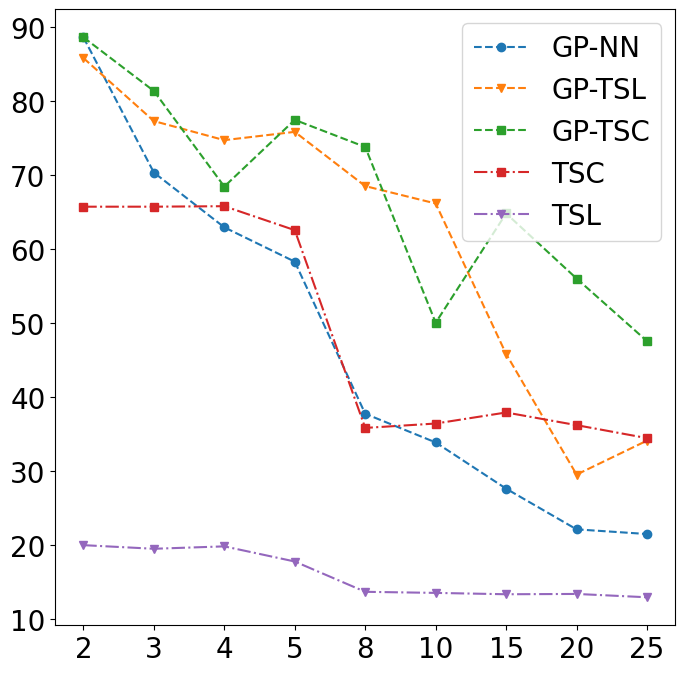

In [19]:
# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_nn_tsl_train_accuracy).reshape(-1, 10), axis=1), '--o', label='GP-NN')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsl_train_accuracy).reshape(-1, 10), axis=1), '--v', label='GP-TSL')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsc_train_accuracy).reshape(-1, 10), axis=1), '--s', label='GP-TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_train_accuracy).reshape(-1, 10), axis=1), '-.s', label='TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_train_accuracy).reshape(-1, 10), axis=1), '-.v', label='TSL')


plt.legend()
plt.show()

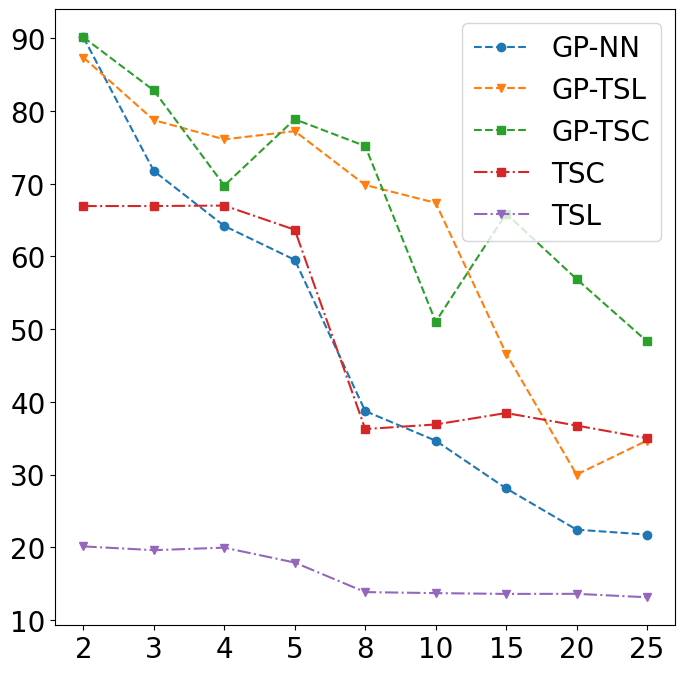

In [20]:
# Plot the results
number_of_rules_array_strings = [str(number) for number in number_of_rules_array]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_nn_tsl_test_accuracy).reshape(-1, 10), axis=1), '--o', label='GP-NN')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsl_test_accuracy).reshape(-1, 10), axis=1), '--v', label='GP-TSL')
ax.plot(number_of_rules_array_strings, np.mean(np.array(gp_tsc_test_accuracy).reshape(-1, 10), axis=1), '--s', label='GP-TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsc_test_accuracy).reshape(-1, 10), axis=1), '-.s', label='TSC')
ax.plot(number_of_rules_array_strings, np.mean(np.array(tsl_test_accuracy).reshape(-1, 10), axis=1), '-.v', label='TSL')


plt.legend()
plt.show()